In [34]:
# load necessary libraries. install what you don't have
import numpy as np
import pandas as pd
import requests
import requests
import urllib
import os
import pprint
import json
import matplotlib.pyplot as plt
import seaborn as sns
import nltk 
import sklearn 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model


In [17]:
# upload data files

# upload metadata
file_meta = "movies_metadata_reduced.jsonl"
meta_list = [json.loads(line) for line in open(file_meta, 'r')]

#upload reviews data
file_rev = "movies_reviews_reduced.jsonl"
rev_list = [json.loads(line) for line in open(file_rev, 'r')]
rev_list[0]



{'rating': 5.0,
 'title': 'Must watch!',
 'text': 'I love this series!',
 'parent_asin': 'B00PSLQYWE'}

In [18]:
# make a data frame for the reviews 
rev_df = pd.DataFrame(rev_list) 
rev_df.head(10)


,rating,title,text,parent_asin
0,5.0,Must watch!,I love this series!,B00PSLQYWE
1,5.0,number 2 in the series and its a good one - lo...,number 2 in the series and its a good one - lo...,B003PIUC02
2,5.0,Great price for blue ray,Gift for son. Great price for blue ray.,B004R6JG7G
3,5.0,Miracle on 34th Street,"I purchased this as a gift, along with some ot...",B075498GH2
4,5.0,Twilight Saga,"I have always liked vampire movies, & Twilight...",B01JTQ3LFG
5,5.0,Five Stars,Excelent.,B00RL9WRAE
6,5.0,Five Stars,great comedy..I love these shows and the quali...,B00EC828DI
7,4.0,"Believe in yourself, not your appearance",Penelope is a modern-day fairytale involving a...,B0011N1WE8
8,4.0,Fans of Ghost and Mrs. Muir and Somewhere in T...,Jennifer Jones ([[ASIN:B00008LDO7 The Song of ...,B0002KPHYC
9,5.0,Great Memories,"Was just as ""she"" remembered it. Great Gift, ...",B002C6A6FY


In [19]:
# make a data frame for the metadata, dropping unnecessary columns
# list the na values in each  column
meta_df = pd.DataFrame(meta_list)
print(meta_df.isna().sum())
# remove columns that are irrelevant or have over 3000 mising values
meta_df = pd.DataFrame(meta_list).drop(columns=['images', 'videos','subtitle','description', 'price', 'bought_together', 'title', 'categories','author', 'store', 'features'])
# show final metadata dataframe
meta_df.head()

main_category       351
title              3145
subtitle           7368
average_rating        3
rating_number         3
features           3145
description        3145
price              4860
images                0
videos                0
store              3550
categories         3145
details               0
parent_asin           0
bought_together    7477
author             7475
dtype: int64


,main_category,average_rating,rating_number,details,parent_asin
0,Prime Video,3.4,29.0,"{'Audio languages': ['English'], 'Subtitles': ...",B0728FHHYC
1,Movies & TV,3.4,36.0,"{'Format': 'Multiple Formats, AC-3, Blu-ray, C...",B001LM64H4
2,Prime Video,3.1,8.0,"{'Audio languages': ['English'], 'Subtitles': ...",B00O8NP6XQ
3,Movies & TV,4.2,15.0,"{'Genre': 'Military & War', 'Format': 'Multipl...",B00JAD6DBI
4,Movies & TV,3.3,139.0,"{'Genre': 'Comedy', 'Format': 'PAL', 'Runtime'...",B07FFG3K2G


In [23]:
# merge metadata with review data
df_merged = rev_df.merge(meta_df, on='parent_asin', how='right')
df_merged.head(5)

,rating,title,text,parent_asin,main_category,average_rating,rating_number,details
0,3.0,Predictable but with promise,It had a pacing problem. It was slow in parts ...,B0728FHHYC,Prime Video,3.4,29.0,"{'Audio languages': ['English'], 'Subtitles': ..."
1,1.0,Bali: Very Disappointing,I have bought ALL the blu ray disks in this Ea...,B001LM64H4,Movies & TV,3.4,36.0,"{'Format': 'Multiple Formats, AC-3, Blu-ray, C..."
2,1.0,Boring,I have been to Bali and I loved it. This video...,B001LM64H4,Movies & TV,3.4,36.0,"{'Format': 'Multiple Formats, AC-3, Blu-ray, C..."
3,3.0,Beautiful but disappointing,Having spent close to three weeks in Bali in 2...,B001LM64H4,Movies & TV,3.4,36.0,"{'Format': 'Multiple Formats, AC-3, Blu-ray, C..."
4,3.0,Beautiful footage but lousy music,I love the Earthscapes series and the beauty o...,B001LM64H4,Movies & TV,3.4,36.0,"{'Format': 'Multiple Formats, AC-3, Blu-ray, C..."


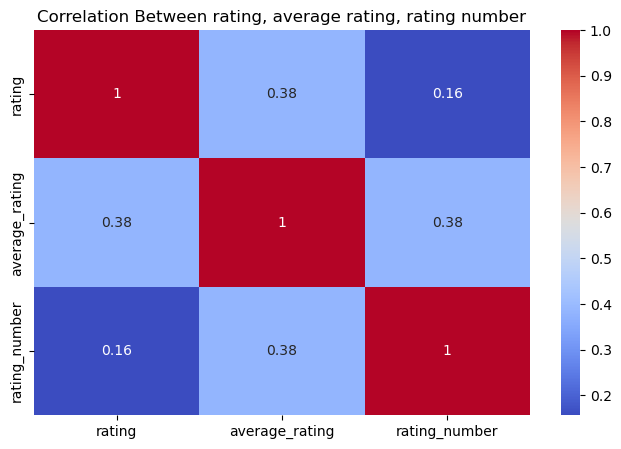

In [12]:
# find a correlation between the quantitative variables in the merged dataset
corr_df = df_merged.select_dtypes(include=['float64'])
correlation_matrix = corr_df.corr()

# plot a correlation matrix for average rating, rating, and amount of ratiangs per movie
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Between rating, average rating, rating number')
plt.show()

#main conclusion is that the metadata might not actually do much to stregthen the model. 

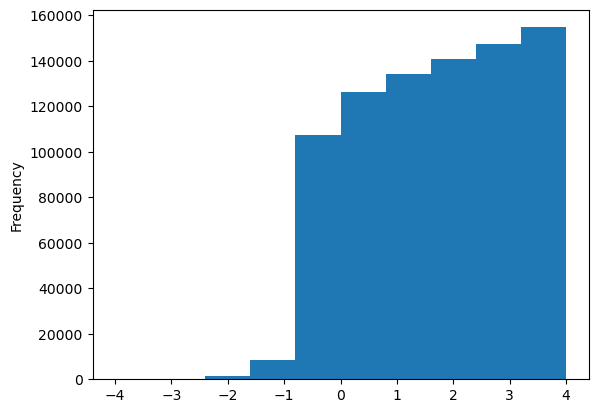

In [26]:
# observe overall difference in user ratings and the average rating for a given movie

# postive diff = user is lower than average, negative diff = user is higher than average 

#created "rating_diff" to observe movie average rating - user rating points
df_merged['rating_diff'] = df_merged['average_rating'] - df_merged['rating']
# plot histogram of frequency distribution of how user ratings differ from the average
ax = df_merged["rating_diff"].plot.hist(orientation="vertical", cumulative=True)
# observe that users tend to rate a movie as lower than the average. 


In [27]:
from nltk.sentiment import SentimentIntensityAnalyzer
#load the nltk sentiment score analyzer. 
# make sure you receive "Package vader_lexicon is already up-to-date! message
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/cnd3ru/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [28]:
# create function to produce the sentiment scores per each review in the review dataframe
def get_sentiment_scores(df):
    # Create an empty list to store sentiment scores
    sentiment_scores = []

    # Iterate over each review text
    for review in df["text"]:
        sentiment = sia.polarity_scores(str(review))  # Convert to string & analyze
        sentiment_scores.append(sentiment["compound"])  # Extract compound score

    # Add sentiment score column
    df["sentiment_score"] = sentiment_scores

    return df  


In [29]:
# produce the sentiment scores for each review, this may take about a minute
# not using the merged data since EDA showed the metadata didn't seem to have factors that would strengthen the model
rev_df_s = get_sentiment_scores(rev_df)
rev_df_s.head(10)

,rating,title,text,parent_asin,sentiment_score
0,5.0,Must watch!,I love this series!,B00PSLQYWE,0.6696
1,5.0,number 2 in the series and its a good one - lo...,number 2 in the series and its a good one - lo...,B003PIUC02,0.8748
2,5.0,Great price for blue ray,Gift for son. Great price for blue ray.,B004R6JG7G,0.7906
3,5.0,Miracle on 34th Street,"I purchased this as a gift, along with some ot...",B075498GH2,0.9825
4,5.0,Twilight Saga,"I have always liked vampire movies, & Twilight...",B01JTQ3LFG,0.6908
5,5.0,Five Stars,Excelent.,B00RL9WRAE,0.0000
6,5.0,Five Stars,great comedy..I love these shows and the quali...,B00EC828DI,0.8519
7,4.0,"Believe in yourself, not your appearance",Penelope is a modern-day fairytale involving a...,B0011N1WE8,0.4122
8,4.0,Fans of Ghost and Mrs. Muir and Somewhere in T...,Jennifer Jones ([[ASIN:B00008LDO7 The Song of ...,B0002KPHYC,0.9955
9,5.0,Great Memories,"Was just as ""she"" remembered it. Great Gift, ...",B002C6A6FY,0.8720


In [39]:
#transform rating and sentiment score columns to an array
y = rev_df_s['rating'].to_numpy()
x = rev_df_s['sentiment_score'].to_numpy()


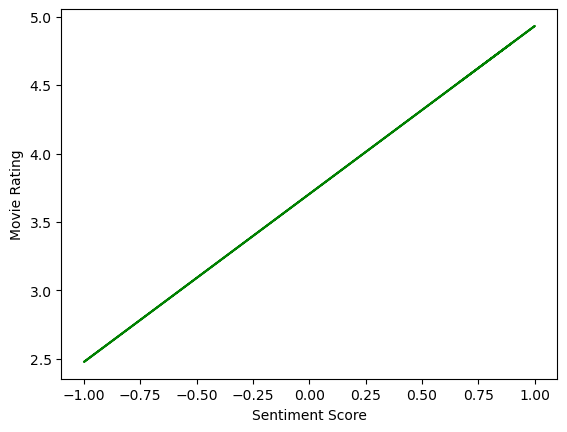

In [40]:

# predict the sentiment score with regression model
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

# function to produce the linear regression coefficients
def estimate_coef(x, y):
  # number of observations/points
  n = np.size(x)

  # mean of x and y vector
  m_x = np.mean(x)
  m_y = np.mean(y)

  # calculating cross-deviation and deviation about x
  SS_xy = np.sum(y*x) - n*m_y*m_x
  SS_xx = np.sum(x*x) - n*m_x*m_x

  # calculating regression coefficients
  b_1 = SS_xy / SS_xx
  b_0 = m_y - b_1*m_x

  return (b_0, b_1)

# function to plot the regression line

def plot_regression_line(x, y, b):
  # plotting the actual points as scatter plot
  #plt.scatter(x, y, color = "m",
       # marker = "o", s = 30)

  # predicted response vector
  y_pred = b[0] + b[1]*x

  # plotting the regression line
  plt.plot(x, y_pred, color = "g")

  # putting labels
  plt.xlabel('Sentiment Score')
  plt.ylabel('Movie Rating')

b_array = []

b_array = estimate_coef(x, y)

#plot the regression line based on the linear reg coefficients for the ratings vs sentiment score model

plot_regression_line(x, y, b_array)


In [52]:
# identify the linear model to test
model = linear_model.LinearRegression()

# test the model using cross-validation scoring for regression. 
# commented below are the guide for the parameters
# model = linear regression
# x = sentiment score
# y = ratings
# scoring = the way we evaluate success of the predictive model, neg mean square error
# cv = "subsets" to test the data. 
mse_scores = cross_val_score(model, x.reshape(-1, 1), y.reshape(-1, 1), scoring='neg_mean_squared_error', cv=5)
#take the negative of the output to get the actual root mean square error values
cv_mse = -mse_scores
mean_cv_mse = np.mean(cv_mse)
# Print the list of tested mean square error values, and the average mse
print(cv_mse)
print("Average of mean square error scores: ", mean_cv_mse)
# Print the list of tested r squared values, and the average r squared
r_square_scores = cross_val_score(model, x.reshape(-1, 1), y.reshape(-1, 1), cv=5)
print(r_square_scores)
print("Average of r squared scores: ",np.mean(r_square_scores))




[1.15213354 1.15426228 1.18062682 1.20500851 1.34291891]
Average of mean square error scores:  1.2069900114701146
[0.2107454  0.20328359 0.2193865  0.2240915  0.25207721]
Average of r squared scores:  0.22191684006042217


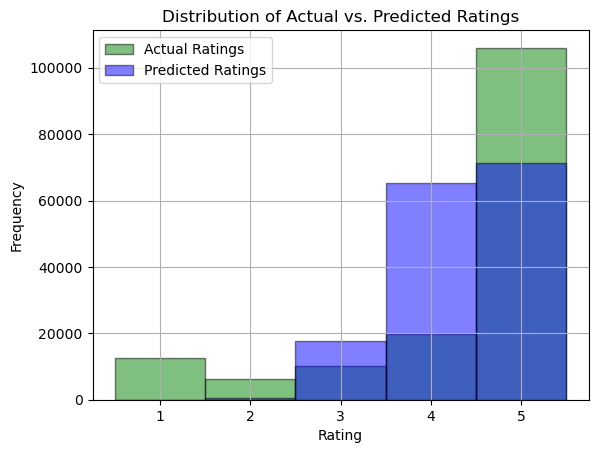

In [53]:
# Plot the distribution 
y_pred = b_array[0] + b_array[1] * x

# Define the bins for ratings 1-5
bins = np.arange(1, 7) - 0.5  # This creates bins for 1, 2, 3, 4, 5

# Plotting Actual and Predicted Ratings
plt.hist(y, bins=bins, alpha=0.5, label='Actual Ratings', color='green', edgecolor='black')
plt.hist(y_pred, bins=bins, alpha=0.5, label='Predicted Ratings', color='blue', edgecolor='black')

# Set labels, title, and grid
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Actual vs. Predicted Ratings')

# Set the x-ticks to 1, 2, 3, 4, 5, so the x-axis shows only these integer values
plt.xticks([1, 2, 3, 4, 5])

# Add a legend and grid
plt.legend(loc='upper left')
plt.grid(True)

# Show the plot
plt.show()


In [55]:


# Calculate predictions using the regression line coefficients
y_pred_lr = b_array[0] + b_array[1] * x

# Calculate residuals (actual - predicted)
residuals = y - y_pred_lr

# Create a box plot of the residuals
#bar graph of the linear reg residuals here


In [56]:
# 1. Make predictions using the fitted linear regression model

# 2. Round the predictions to the nearest integer (since ratings are discrete)
y_pred_lr_rounded = np.round(y_pred_lr).astype(int)

# 3. Calculate the accuracy by comparing the rounded predictions to the actual ratings
accuracy_lr = np.mean(y_pred_lr_rounded == y) * 100  # Multiply by 100 to get percentage

print(f"Accuracy of the Linear Regression model: {accuracy_lr:.2f}%")


Accuracy of the Linear Regression model: 42.60%


/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packag

Cross-Validated Mean Squared Error: 1.2122
Final Test Mean Squared Error: 1.1945
Final Test R-squared Score: 0.2240


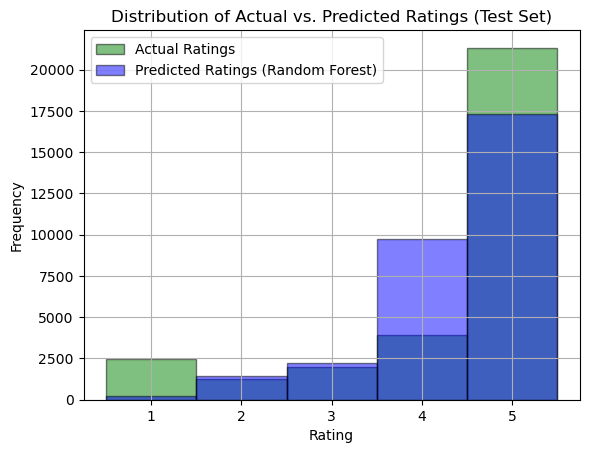

In [49]:
# Replicating the methodology above but this time with a randomforest regression model instead of linear regression
# This will run, but it make take a few minutes!

# Initialize the new model
rf_model = RandomForestRegressor(n_estimators=100, random_state=6)

# 1. Perform Cross-Validation on random forest model
cv_scores = cross_val_score(rf_model, x.reshape(-1, 1), y.reshape(-1, 1), scoring='neg_mean_squared_error', cv=5)
cv_mse = -cv_scores  # Convert to positive MSE
mean_cv_mse = np.mean(cv_mse)

print(f"Cross-Validated Mean Squared Error: {mean_cv_mse:.4f}")

# 2. Fit new model and test MSE and r2 of the fitted model that uses the split test vs. train data as opposed to the cross_val score (cross_val_score is likely more reliable but this also provides an additional metric)
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x.reshape(-1, 1), y, test_size=0.2, random_state=42)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

print(f"Final Test Mean Squared Error: {mse:.4f}")
print(f"Final Test R-squared Score: {r2:.4f}")

# Plotting the actual ratings vs predicted ones in a histogram for the randomforest regression model (seems better than linear model)
#Predictions are made with continious numbers to capture some of the nuance in reviews but then rounded to nearest integer for graph purposes
bins = np.arange(1, 7) - 0.5  # Bins for ratings 1-5

plt.hist(y_test, bins=bins, alpha=0.5, label='Actual Ratings', color='green', edgecolor='black')
plt.hist(y_pred_rf, bins=bins, alpha=0.5, label='Predicted Ratings (Random Forest)', color='blue', edgecolor='black')

plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Actual vs. Predicted Ratings (Test Set)')
plt.xticks([1, 2, 3, 4, 5])
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


In [50]:
# 1. Calculate predictions using the fitted Random Forest model
y_pred_rf = rf_model.predict(X_test)

# 2. Calculate residuals (actual - predicted)
residuals_rf = y_test - y_pred_rf

# 3. Create a bar plot of the residuals


In [51]:
# 1. Make predictions using the fitted Random Forest model
y_pred_rf = rf_model.predict(X_test)

# 2. Round the predictions to the nearest integer (since ratings are discrete)
y_pred_rf_rounded = np.round(y_pred_rf).astype(int)

# 3. Calculate the accuracy by comparing the rounded predictions to the actual ratings
accuracy = np.mean(y_pred_rf_rounded == y_test) * 100  # Multiply by 100 to get percentage

print(f"Accuracy of the Random Forest model: {accuracy:.2f}%")


Accuracy of the Random Forest model: 53.13%
